# Time-LLM

Install the dependencies.

In [1]:
!pip install transformers sentencepiece

Import the dependencies.

In [2]:
import os
import types
import random
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, median_absolute_error, root_mean_squared_error

from models.TimeLLM import Model

Set the device.

In [3]:
device = torch.device("cuda:0")

Fix all random seeds.

In [4]:
random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Get the data. 

In [5]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jbrownlee/Datasets/refs/heads/master/airline-passengers.csv",
    parse_dates=["Month"],
    dtype=float
)

In [6]:
df.shape

(144, 2)

In [7]:
df.head()

,Month,Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Visualize the data.

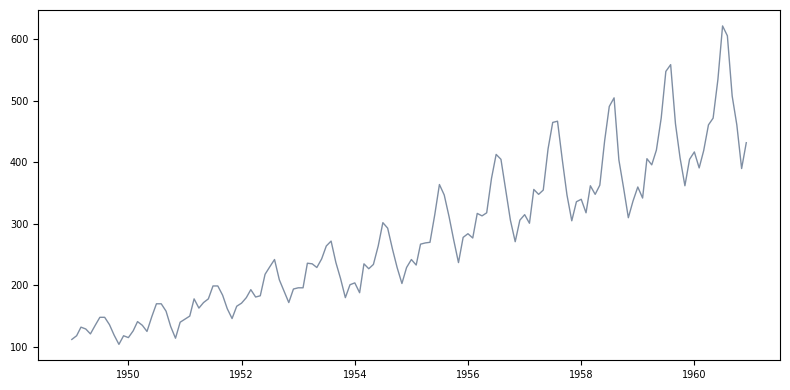

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df["Month"], df["Passengers"], color="#7f8ea3", lw=1)
ax.xaxis.set_tick_params(labelbottom=True)
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.tight_layout()
fig.show()

Define the sequence lenghts.

In [9]:
seq_len = 24
pred_len = 12

Split the data into training and test sets.

In [10]:
df_train = df[["Passengers"]].iloc[:- pred_len]
df_test = df[["Passengers"]].iloc[- (seq_len + pred_len):]

Calculate the scaling parameters.

In [11]:
mu = df_train.mean(axis=0).item()
sigma = df_train.std(axis=0, ddof=1).item()

Scale the data.

In [12]:
df_train = (df_train - mu) / sigma
df_test = (df_test - mu) / sigma

Define a function for splitting the data into input and output sequences. 

In [13]:
def get_sequences(df, seq_len, pred_len):
    x = []
    y = []
    for t in range(seq_len, len(df) - pred_len + 1):
        x.append(df.iloc[t - seq_len: t].values)
        y.append(df.iloc[t: t + pred_len].values)
    x = np.array(x)
    y = np.array(y)
    return x, y

Generate the training sequences.

In [14]:
x_train, y_train = get_sequences(df_train, seq_len, pred_len)

Generate the test sequences.

In [15]:
x_test, y_test = get_sequences(df_test, seq_len, pred_len)

Define the training parameters.

In [16]:
batch_size = 8
lr = 0.001
epochs = 40

Create the training dataset.

In [17]:
dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(x_train).float(),
    torch.from_numpy(y_train).float()
)

Create the training dataloader.

In [18]:
dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
)

Instantiate the model.

In [19]:
model = Model(
    configs=types.SimpleNamespace(
        prompt_domain=True,
        content="Monthly totals of a airline passengers from USA, from January 1949 through December 1960.",
        task_name="short_term_forecast",  # not used
        enc_in=None,  # not used
        pred_len=pred_len,
        seq_len=seq_len,
        llm_model="LLAMA",
        llm_dim=4096,
        llm_layers=1,
        d_model=32,
        d_ff=32,
        patch_len=16,
        stride=8,
        n_heads=4,
        dropout=0,
    )
)
model.to(torch.bfloat16)
model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model(
  (llm_model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
      )
    )
    (no

In [20]:
print(f"Number of parameters: {format(sum(p.numel() for p in model.parameters()), ',.0f')}")
print(f"Number of frozen parameters: {format(sum(p.numel() for p in model.parameters() if not p.requires_grad), ',.0f')}")
print(f"Number of trainable parameters: {format(sum(p.numel() for p in model.parameters() if p.requires_grad), ',.0f')}")

Number of parameters: 367,044,596
Number of frozen parameters: 333,459,456
Number of trainable parameters: 33,585,140


Instantiate the optimizer.

In [21]:
optimizer = torch.optim.Adam(
    params=[p for p in model.parameters() if p.requires_grad],
    lr=lr
)

Train the model.

In [22]:
model.train()
for epoch in range(epochs):
    losses = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        yhat = model(
            x_enc=x,
            x_mark_enc=None,
            x_dec=None,
            x_mark_dec=None
        )
        loss = torch.nn.functional.mse_loss(yhat, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'epoch: {format(1 + epoch, ".0f")} loss: {format(np.mean(losses), ",.8f")}')

epoch: 1 loss: 0.29851346
epoch: 2 loss: 0.15955588
epoch: 3 loss: 0.08472076
epoch: 4 loss: 0.05967870
epoch: 5 loss: 0.06023220
epoch: 6 loss: 0.06349146
epoch: 7 loss: 0.06728122
epoch: 8 loss: 0.06126707
epoch: 9 loss: 0.05353234
epoch: 10 loss: 0.05658055
epoch: 11 loss: 0.04822905
epoch: 12 loss: 0.04843022
epoch: 13 loss: 0.04471244
epoch: 14 loss: 0.05880081
epoch: 15 loss: 0.05236155
epoch: 16 loss: 0.05229929
epoch: 17 loss: 0.04131612
epoch: 18 loss: 0.03974260
epoch: 19 loss: 0.04010143
epoch: 20 loss: 0.04502358
epoch: 21 loss: 0.05139145
epoch: 22 loss: 0.04821363
epoch: 23 loss: 0.05030083
epoch: 24 loss: 0.04305501
epoch: 25 loss: 0.03821681
epoch: 26 loss: 0.03685588
epoch: 27 loss: 0.04157941
epoch: 28 loss: 0.03874546
epoch: 29 loss: 0.04502921
epoch: 30 loss: 0.04382845
epoch: 31 loss: 0.04558949
epoch: 32 loss: 0.04334464
epoch: 33 loss: 0.04241312
epoch: 34 loss: 0.03419355
epoch: 35 loss: 0.03252470
epoch: 36 loss: 0.03761013
epoch: 37 loss: 0.03659076
epoch: 38 

Generate the forecasts.

In [23]:
model.eval()
yhat_test = model(
    x_enc=torch.from_numpy(x_test).float().to(device),
    x_mark_enc=None,
    x_dec=None,
    x_mark_dec=None
).detach().cpu().numpy().flatten()

Transform the forecasts back to the original scale.

In [24]:
yhat_test = mu + sigma * yhat_test

Organize the forecasts in a data frame.

In [25]:
predictions = pd.DataFrame(
    data=yhat_test,
    columns=["Passengers"],
    index=df["Month"].iloc[-pred_len:]
).reset_index()

In [26]:
predictions

,Month,Passengers
0,1960-01-01,391.472290
1,1960-02-01,388.123474
2,1960-03-01,444.852570
3,1960-04-01,443.780945
4,1960-05-01,455.300903
5,1960-06-01,540.762878
6,1960-07-01,617.919800
7,1960-08-01,618.991394
8,1960-09-01,527.367554
9,1960-10-01,438.958618


Visualize the forecasts.

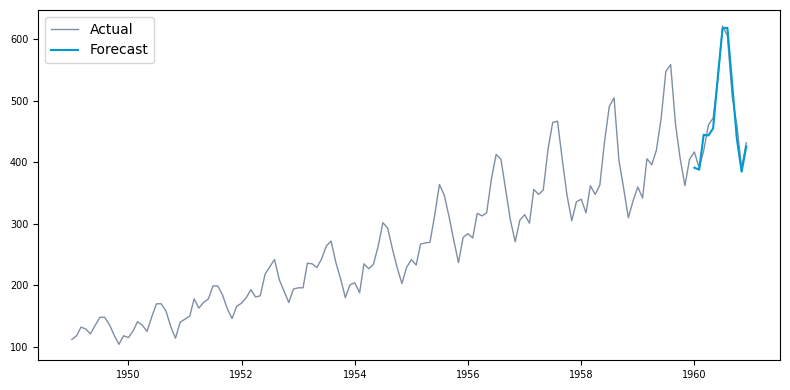

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df["Month"], df["Passengers"], color="#7f8ea3", lw=1, label="Actual")
ax.plot(predictions["Month"], predictions["Passengers"], color="#009ad3", lw=1.5, label="Forecast")
ax.xaxis.set_tick_params(labelbottom=True)
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
ax.legend(loc=0)
fig.tight_layout()
fig.show()

Calculate the error metrics.

In [28]:
metrics = pd.DataFrame({
    "Mean Absolute Error": mean_absolute_error(y_true=df["Passengers"].iloc[-pred_len:], y_pred=predictions["Passengers"]),
    "Median Absolute Error": median_absolute_error(y_true=df["Passengers"].iloc[-pred_len:], y_pred=predictions["Passengers"]),
    "Root Mean Squared Error": root_mean_squared_error(y_true=df["Passengers"].iloc[-pred_len:], y_pred=predictions["Passengers"]),
}, index=[""]).transpose()

In [29]:
metrics

,
Mean Absolute Error,13.623131
Median Absolute Error,14.845245
Root Mean Squared Error,15.928585
